# Nikshay Jain - MM21B044
# Sujal Burad  - EE21B144

### Link to notebook: https://www.kaggle.com/code/nikshay/ee6180-assignment-3-mm21b044-ee21b144

In [1]:
!nproc ## To check the number of cores

4


In [2]:
! pip install mpi4py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 15.8 MB/s eta 0:00:00


In [3]:
%%writefile 00spmd.py
from mpi4py import MPI

def main():
    comm = MPI.COMM_WORLD
    id = comm.Get_rank()            #number of the process running the code
    numProcesses = comm.Get_size()  #total number of processes running
    myHostName = MPI.Get_processor_name()  #machine name running the code

    print("Greetings from process {} of {} on {}"\
    .format(id, numProcesses, myHostName))
    
########## Run the main function
main()

Writing 00spmd.py


In [4]:
! mpirun --allow-run-as-root --oversubscribe -np 8 python 00spmd.py

Greetings from process 7 of 8 on 251c88f5ad37
Greetings from process 3 of 8 on 251c88f5ad37
Greetings from process 0 of 8 on 251c88f5ad37
Greetings from process 2 of 8 on 251c88f5ad37
Greetings from process 5 of 8 on 251c88f5ad37
Greetings from process 4 of 8 on 251c88f5ad37
Greetings from process 1 of 8 on 251c88f5ad37
Greetings from process 6 of 8 on 251c88f5ad37


## Uncoded Linear Regression

In [5]:
%%writefile distributed_lr_uncoded.py
import numpy as np
from mpi4py import MPI
import time
import pickle

def main():
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()
    size = comm.Get_size()
    
    # Parameters
    max_iterations = 100
    learning_rate = 0.001
    num_workers = size - 1    # Rank 0 is master
    
    if rank == 0:
        # Master: Load data
        print(f"Master (Rank 0): Loading data for {num_workers} workers")
        
        X_train = np.load('/kaggle/input/gisette-dataset/X_train.npy')
        y_train = np.load('/kaggle/input/gisette-dataset/y_train.npy')
        X_val = np.load('/kaggle/input/gisette-dataset/X_val.npy')
        y_val = np.load('/kaggle/input/gisette-dataset/y_val.npy')
        y_train[y_train == -1] = 0
        y_val[y_val == -1] = 0
        mean=np.mean(X_train,0)
        std=np.std(X_train,0)+1e-8
        X_train=(X_train-mean)/std
        X_val=(X_val-mean)/std
        # X_train=np.column_stack((np.ones(X_train.shape[0]),X_train))
        # X_val=np.column_stack((np.ones(X_val.shape[0]),X_val))

        q, p = X_train.shape
        rows_per_worker = q // num_workers
        
        print(f"Data shape: {X_train.shape}, Rows per worker: {rows_per_worker}")
        
        # Initialize model
        w = np.zeros(p)
        
        # Metrics storage
        train_losses = []
        val_losses = []
        val_accuracies = []
        iteration_times = []
        
    else:
        X_train = None
        y_train = None
        X_val = None
        y_val = None
        q = None
        p = None
        rows_per_worker = None
        w = None
    
    # Broadcast dimensions
    q = comm.bcast(q if rank == 0 else None, root=0)
    p = comm.bcast(p if rank == 0 else None, root=0)
    rows_per_worker = comm.bcast(rows_per_worker if rank == 0 else None, root=0)
    
    if rank > 0:
        # Workers: Allocate space for local data
        X_local = np.empty((rows_per_worker, p), dtype='d')
        y_local = np.empty(rows_per_worker, dtype='d')
        w = np.empty(p, dtype='d')
    
    # Distribute data to workers
    if rank == 0:
        for i in range(1, size):
            start = (i - 1) * rows_per_worker
            comm.Send(X_train[start:start + rows_per_worker, :].copy(), dest=i, tag=0)
            comm.Send(y_train[start:start + rows_per_worker].copy(), dest=i, tag=1)
        print("Master: Data distribution completed")
    else:
        comm.Recv(X_local, source=0, tag=0)
        comm.Recv(y_local, source=0, tag=1)
    
    # Gradient Descent Iterations
    for iteration in range(max_iterations):
        iter_start_time = MPI.Wtime()
        
        # Broadcast current weights
        comm.Bcast(w, root=0)
        
        # Workers: Compute local gradient
        if rank > 0:
            # X_local @ w - y_local
            residual = np.dot(X_local, w) - y_local
            # Local gradient: X_local.T @ residual
            local_gradient = np.dot(X_local.T, residual)
        else:
            local_gradient = np.zeros(p)
        
        # Gather gradients at master
        if rank == 0:
            global_gradient = np.zeros(p)
            worker_gradients = []
            for i in range(1, size):
                worker_grad = np.empty(p, dtype='d')
                comm.Recv(worker_grad, source=i, tag=2)
                worker_gradients.append(worker_grad)
            
            # Sum all gradients
            global_gradient = np.sum(worker_gradients, axis=0)
            # Average: divide by total number of samples q
            global_gradient /= q
            
            # Update weights
            w -= learning_rate * global_gradient
            
            # Compute training loss
            train_loss = 0.0
            for i in range(1, size):
                local_loss = np.empty(1, dtype='d')
                comm.Recv(local_loss, source=i, tag=3)
                train_loss += local_loss[0]
            train_loss = train_loss / (2 * q)
            train_losses.append(train_loss)
            
            # Compute validation metrics
            y_val_pred = np.dot(X_val, w)
            val_loss = np.sum((y_val_pred - y_val) ** 2) / (2 * len(y_val))
            val_losses.append(val_loss)
            
            # Validation accuracy (assuming binary classification with threshold 0)
            y_val_pred_class = (y_val_pred >= 0.5).astype(int)
            val_acc = np.mean(y_val_pred_class == y_val)
            val_accuracies.append(val_acc)
            
            iter_end_time = MPI.Wtime()
            iter_time = iter_end_time - iter_start_time
            iteration_times.append(iter_time)
            
            if (iteration + 1) % 10 == 0:
                print(f"Iter {iteration+1}: Train Loss={train_loss:.4f}, "
                      f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}, "
                      f"Time={iter_time:.4f}s")
        else:
            # Send gradient to master
            comm.Send(local_gradient, dest=0, tag=2)
            
            # Send local loss
            residual = np.dot(X_local, w) - y_local
            local_loss = np.array([np.sum(residual ** 2)])
            comm.Send(local_loss, dest=0, tag=3)
    
    # Save results
    if rank == 0:
        results = {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'val_accuracies': val_accuracies,
            'iteration_times': iteration_times,
            'cumulative_times': np.cumsum(iteration_times),
            'final_weights': w
        }
        with open('uncoded_results.pkl', 'wb') as f:
            pickle.dump(results, f)
        print("\nUncoded training completed!")
        print(f"Final Train Loss: {train_losses[-1]:.4f}")
        print(f"Final Val Loss: {val_losses[-1]:.4f}")
        print(f"Final Val Accuracy: {val_accuracies[-1]:.4f}")
        print(f"Total time taken: {np.cumsum(iteration_times)[-1]:.4f}")

if __name__ == '__main__':
    main()

Writing distributed_lr_uncoded.py


In [6]:
print("=" * 50)
print("RUNNING UNCODED DISTRIBUTED LINEAR REGRESSION")
print("=" * 50)
!mpirun --allow-run-as-root --oversubscribe -np 9 python distributed_lr_uncoded.py

RUNNING UNCODED DISTRIBUTED LINEAR REGRESSION
Master (Rank 0): Loading data for 8 workers
Data shape: (6000, 5000), Rows per worker: 750
Master: Data distribution completed
Iter 10: Train Loss=0.1871, Val Loss=0.1840, Val Acc=0.5030, Time=0.0403s
Iter 20: Train Loss=0.1688, Val Loss=0.1673, Val Acc=0.5310, Time=0.0388s
Iter 30: Train Loss=0.1619, Val Loss=0.1608, Val Acc=0.5590, Time=0.0441s
Iter 40: Train Loss=0.1583, Val Loss=0.1575, Val Acc=0.5720, Time=0.0449s
Iter 50: Train Loss=0.1561, Val Loss=0.1555, Val Acc=0.5900, Time=0.0500s
Iter 60: Train Loss=0.1544, Val Loss=0.1542, Val Acc=0.6090, Time=0.0468s
Iter 70: Train Loss=0.1530, Val Loss=0.1531, Val Acc=0.6170, Time=0.0428s
Iter 80: Train Loss=0.1519, Val Loss=0.1523, Val Acc=0.6240, Time=0.0589s
Iter 90: Train Loss=0.1509, Val Loss=0.1516, Val Acc=0.6260, Time=0.0575s
Iter 100: Train Loss=0.1500, Val Loss=0.1509, Val Acc=0.6280, Time=0.1193s

Uncoded training completed!
Final Train Loss: 0.1500
Final Val Loss: 0.1509
Final Val

## Coded Linear Regression (with Straggler Mitigation)

In [7]:
%%writefile distributed_lr_coded.py
import numpy as np
from mpi4py import MPI
import time
import pickle
import random

def main():
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()
    size = comm.Get_size()
    
    max_iterations = 100
    learning_rate = 0.001
    num_workers = size - 1
    min_workers_required = 7  # proceed after receiving this many workers
    
    if rank == 0:
        print(f"Master (Rank 0): Preparing coded setup for {num_workers} workers")
        print(f"Will wait for only {min_workers_required} workers per iteration")
        
        X_train = np.load('/kaggle/input/gisette-dataset/X_train.npy')
        y_train = np.load('/kaggle/input/gisette-dataset/y_train.npy')
        X_val = np.load('/kaggle/input/gisette-dataset/X_val.npy')
        y_val = np.load('/kaggle/input/gisette-dataset/y_val.npy')
        
        y_train[y_train == -1] = 0
        y_val[y_val == -1] = 0
        mean = np.mean(X_train, 0)
        std = np.std(X_train, 0) + 1e-8
        X_train = (X_train - mean) / std
        X_val = (X_val - mean) / std
        # X_train = np.column_stack((np.ones(X_train.shape[0]), X_train))
        # X_val = np.column_stack((np.ones(X_val.shape[0]), X_val))
        
        q, p = X_train.shape
        c = q
        
        np.random.seed(42)
        G = np.random.randn(c, q) / np.sqrt(q)
        
        print("Encoding data with G matrix...")
        X_coded = np.dot(G, X_train)
        y_coded = np.dot(G, y_train)
        
        rows_per_worker = c // num_workers
        print(f"Original data: {X_train.shape}, Coded data: {X_coded.shape}")
        print(f"Rows per worker: {rows_per_worker}")
        
        w = np.zeros(p, dtype='d')
        train_losses = []
        val_losses = []
        val_accuracies = []
        iteration_times = []
        slow_worker = random.randint(1, num_workers)
        print(f"Simulated slow worker: Rank {slow_worker}")
    else:
        X_coded = None
        y_coded = None
        X_val = None
        y_val = None
        q = None
        c = None
        p = None
        rows_per_worker = None
        w = None
        slow_worker = None
    
    # Broadcast scalar/meta values
    q = comm.bcast(q if rank == 0 else None, root=0)
    c = comm.bcast(c if rank == 0 else None, root=0)
    p = comm.bcast(p if rank == 0 else None, root=0)
    rows_per_worker = comm.bcast(rows_per_worker if rank == 0 else None, root=0)
    slow_worker = comm.bcast(slow_worker if rank == 0 else None, root=0)
    
    # Allocate worker-side buffers
    if rank > 0:
        X_local = np.empty((rows_per_worker, p), dtype='d')
        y_local = np.empty(rows_per_worker, dtype='d')
        w = np.empty(p, dtype='d')
    
    # Distribute coded data once
    if rank == 0:
        for i in range(1, size):
            start = (i - 1) * rows_per_worker
            comm.Send(X_coded[start:start + rows_per_worker, :].copy(), dest=i, tag=0)
            comm.Send(y_coded[start:start + rows_per_worker].copy(), dest=i, tag=1)
        print("Master: Coded data distribution completed")
    else:
        comm.Recv(X_local, source=0, tag=0)
        comm.Recv(y_local, source=0, tag=1)
    
    comm.Barrier()
    
    for iteration in range(max_iterations):
        iter_start_time = MPI.Wtime()
        
        # MASTER: send latest weights via non-blocking point-to-point Isend
        if rank == 0:
            send_reqs = []
            for dest in range(1, size):
                # send current w to worker (non-blocking)
                req = comm.Isend(w, dest=dest, tag=100)
                send_reqs.append(req)
            # Do not wait for send_reqs to complete; master proceeds.
        else:
            # WORKER: receive current w via blocking Recv (will get it when master sent it)
            comm.Recv(w, source=0, tag=100)
        
        # WORKER compute and send gradient & loss
        if rank > 0:
            comp_start = MPI.Wtime()
            residual = np.dot(X_local, w) - y_local
            local_gradient = np.dot(X_local.T, residual)
            comp_time = MPI.Wtime() - comp_start
            
            # Simulated slow worker
            if rank == slow_worker:
                time.sleep(10 * comp_time)
            
            # Send gradient and loss (binary Send)
            comm.Isend(local_gradient, dest=0, tag=2)
            local_loss = np.array([np.sum(residual ** 2)], dtype='d')
            comm.Isend(local_loss, dest=0, tag=3)
        
        # MASTER: collect first `min_workers_required` gradients (no waiting for slow)
        if rank == 0:
            worker_gradients = []
            completed_ranks = []
            worker_times = np.zeros(num_workers + 1)
            completed = 0
            
            status = MPI.Status()
            # Poll using Iprobe + Recv for the numeric buffers
            while completed < min_workers_required:
                if comm.Iprobe(source=MPI.ANY_SOURCE, tag=2, status=status):
                    src = status.Get_source()
                    grad_buf = np.empty(p, dtype='d')
                    comm.Recv(grad_buf, source=src, tag=2)
                    worker_gradients.append(grad_buf)
                    completed_ranks.append(src)
                    worker_times[src] = MPI.Wtime() - iter_start_time
                    completed += 1
                else:
                    # avoid tight busy spin
                    time.sleep(0.0005)
            
            # Aggregate gradients and update w
            global_gradient = np.sum(worker_gradients, axis=0)
            global_gradient /= float(c)
            w -= learning_rate * global_gradient
            
            # Collect losses only from completed ranks (they should have been sent by workers)
            train_loss_coded = 0.0
            for src in completed_ranks:
                loss_buf = np.empty(1, dtype='d')
                comm.Recv(loss_buf, source=src, tag=3)
                train_loss_coded += float(loss_buf[0])
            
            # Normalize and store training loss
            train_loss_coded = train_loss_coded / (2 * c)
            train_losses.append(train_loss_coded)
            
            # Validation metrics using current w (master has X_val and y_val)
            y_val_pred = np.dot(X_val, w)
            val_loss = np.sum((y_val_pred - y_val) ** 2) / (2 * len(y_val))
            val_losses.append(val_loss)
            
            y_val_pred_class = (y_val_pred >= 0.5).astype(int)
            val_acc = np.mean(y_val_pred_class == y_val)
            val_accuracies.append(val_acc)
            
            iter_end_time = MPI.Wtime()
            iter_time = iter_end_time - iter_start_time
            iteration_times.append(iter_time)
            
            if (iteration + 1) % 10 == 0:
                print(f"Iter {iteration+1}: Train Loss={train_loss_coded:.4f}, "
                      f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}, "
                      f"Time={iter_time:.4f}s")
                # print(f"  Completed ranks (first {min_workers_required}): {(completed_ranks)}, "
                #       f"Slow worker (Rank {slow_worker}) time (if finished): {worker_times[slow_worker]:.4f}s")

    comm.Barrier()
    
    # After iterations, master saves results
    if rank == 0:
        results = {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'val_accuracies': val_accuracies,
            'iteration_times': iteration_times,
            'cumulative_times': np.cumsum(iteration_times),
            'final_weights': w,
            'slow_worker': slow_worker
        }
        with open('coded_results.pkl', 'wb') as f:
            pickle.dump(results, f)
        print("\nCoded training completed!")
        print(f"Final Train Loss: {train_losses[-1]:.4f}")
        print(f"Final Val Loss: {val_losses[-1]:.4f}")
        print(f"Final Val Accuracy: {val_accuracies[-1]:.4f}")
        print(f"Total time taken: {np.cumsum(iteration_times)[-1]:.4f}")

if __name__ == '__main__':
    main()

Writing distributed_lr_coded.py


In [8]:
print("\n" + "=" * 50)
print("RUNNING CODED DISTRIBUTED LINEAR REGRESSION")
print("=" * 50)
!mpirun --allow-run-as-root --oversubscribe -np 9 python distributed_lr_coded.py


RUNNING CODED DISTRIBUTED LINEAR REGRESSION
Master (Rank 0): Preparing coded setup for 8 workers
Will wait for only 7 workers per iteration
Encoding data with G matrix...
Original data: (6000, 5000), Coded data: (6000, 5000)
Rows per worker: 750
Simulated slow worker: Rank 2
Master: Coded data distribution completed
Iter 10: Train Loss=0.1630, Val Loss=0.1887, Val Acc=0.5000, Time=0.0253s
Iter 20: Train Loss=0.1464, Val Loss=0.1706, Val Acc=0.5170, Time=0.0223s
Iter 30: Train Loss=0.1387, Val Loss=0.1631, Val Acc=0.5400, Time=0.0192s
Iter 40: Train Loss=0.1333, Val Loss=0.1594, Val Acc=0.5590, Time=0.0180s
Iter 50: Train Loss=0.1288, Val Loss=0.1573, Val Acc=0.5800, Time=0.0176s
Iter 60: Train Loss=0.1288, Val Loss=0.1560, Val Acc=0.5900, Time=0.0225s
Iter 70: Train Loss=0.1249, Val Loss=0.1550, Val Acc=0.5960, Time=0.0191s
Iter 80: Train Loss=0.1214, Val Loss=0.1542, Val Acc=0.6030, Time=0.0186s
Iter 90: Train Loss=0.1201, Val Loss=0.1536, Val Acc=0.6080, Time=0.0178s
Iter 100: Train

## Comparison Plots: Uncoded vs Coded Linear Regression

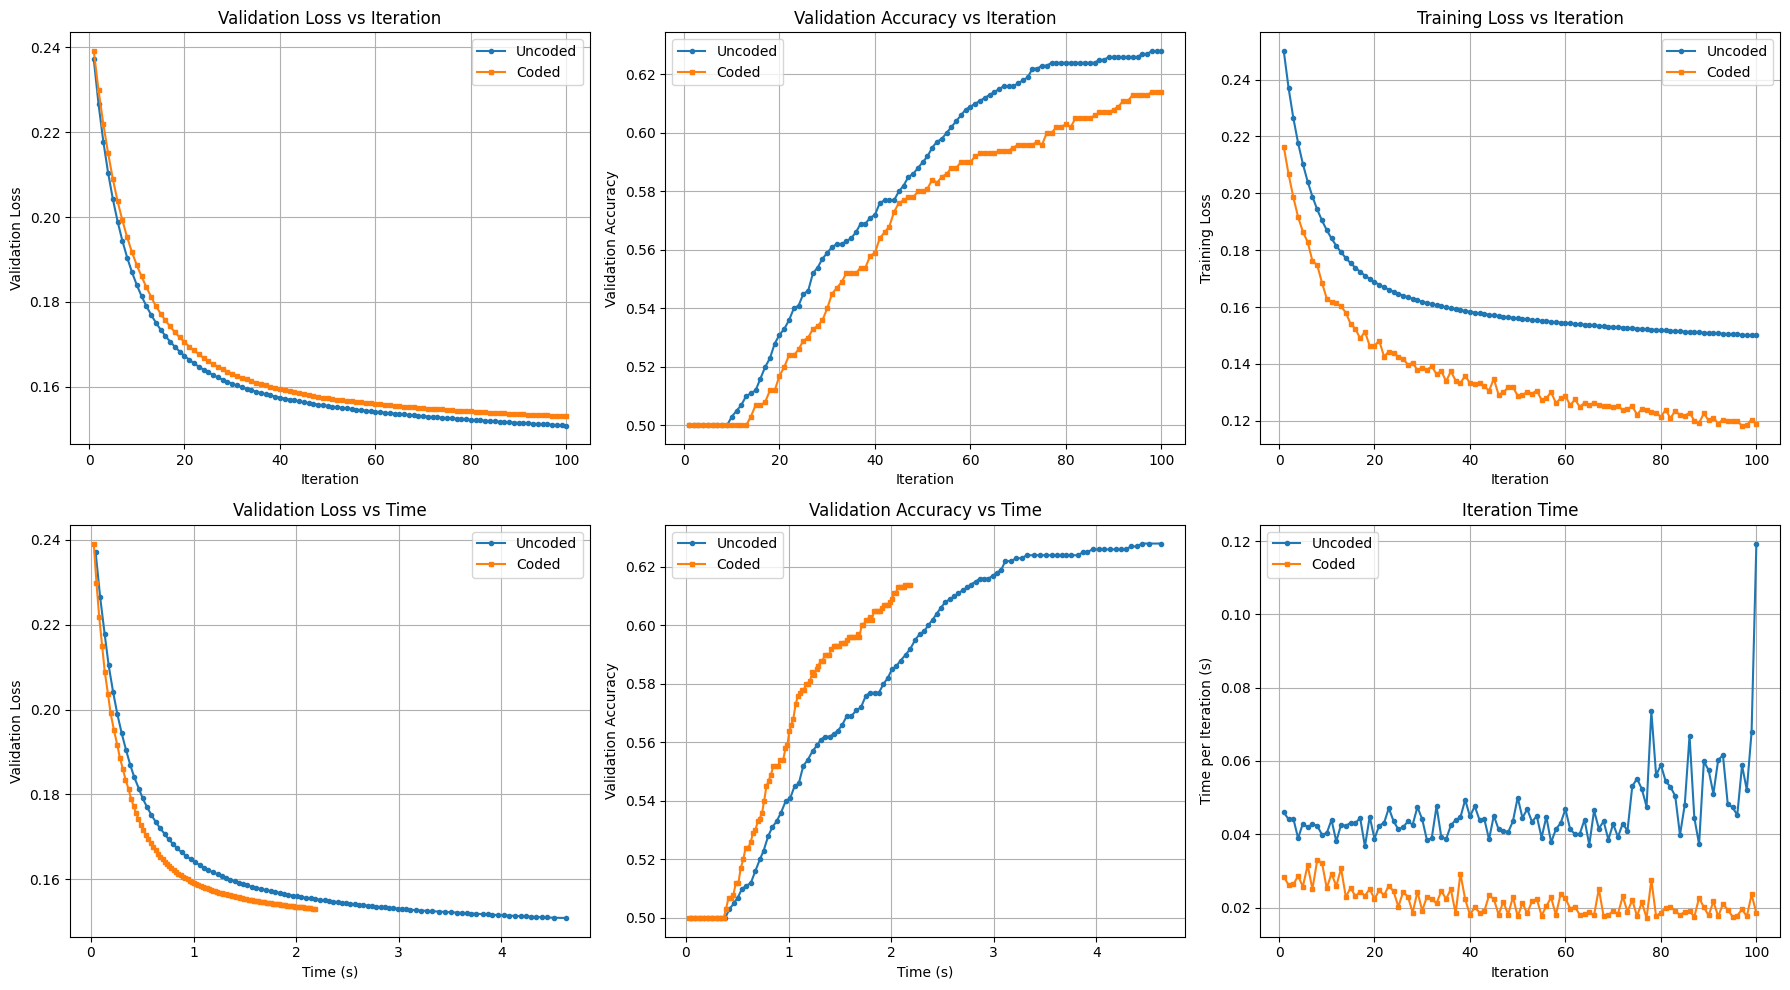


UNCODED: 4.63s, Acc=0.6280
CODED:   2.18s, Acc=0.6140
SPEEDUP: 2.12x


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

with open('uncoded_results.pkl', 'rb') as f:
    uncoded = pickle.load(f)
with open('coded_results.pkl', 'rb') as f:
    coded = pickle.load(f)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
iters_u = range(1, len(uncoded['val_losses']) + 1)
iters_c = range(1, len(coded['val_losses']) + 1)

axes[0,0].plot(iters_u, uncoded['val_losses'], 'o-', label='Uncoded', markersize=3)
axes[0,0].plot(iters_c, coded['val_losses'], 's-', label='Coded', markersize=3)
axes[0,0].set_xlabel('Iteration'); axes[0,0].set_ylabel('Validation Loss')
axes[0,0].set_title('Validation Loss vs Iteration'); axes[0,0].legend(); axes[0,0].grid(True)

axes[0,1].plot(iters_u, uncoded['val_accuracies'], 'o-', label='Uncoded', markersize=3)
axes[0,1].plot(iters_c, coded['val_accuracies'], 's-', label='Coded', markersize=3)
axes[0,1].set_xlabel('Iteration'); axes[0,1].set_ylabel('Validation Accuracy')
axes[0,1].set_title('Validation Accuracy vs Iteration'); axes[0,1].legend(); axes[0,1].grid(True)

axes[0,2].plot(iters_u, uncoded['train_losses'], 'o-', label='Uncoded', markersize=3)
axes[0,2].plot(iters_c, coded['train_losses'], 's-', label='Coded', markersize=3)
axes[0,2].set_xlabel('Iteration'); axes[0,2].set_ylabel('Training Loss')
axes[0,2].set_title('Training Loss vs Iteration'); axes[0,2].legend(); axes[0,2].grid(True)

axes[1,0].plot(uncoded['cumulative_times'], uncoded['val_losses'], 'o-', label='Uncoded', markersize=3)
axes[1,0].plot(coded['cumulative_times'], coded['val_losses'], 's-', label='Coded', markersize=3)
axes[1,0].set_xlabel('Time (s)'); axes[1,0].set_ylabel('Validation Loss')
axes[1,0].set_title('Validation Loss vs Time'); axes[1,0].legend(); axes[1,0].grid(True)

axes[1,1].plot(uncoded['cumulative_times'], uncoded['val_accuracies'], 'o-', label='Uncoded', markersize=3)
axes[1,1].plot(coded['cumulative_times'], coded['val_accuracies'], 's-', label='Coded', markersize=3)
axes[1,1].set_xlabel('Time (s)'); axes[1,1].set_ylabel('Validation Accuracy')
axes[1,1].set_title('Validation Accuracy vs Time'); axes[1,1].legend(); axes[1,1].grid(True)

axes[1,2].plot(iters_u, uncoded['iteration_times'], 'o-', label='Uncoded', markersize=3)
axes[1,2].plot(iters_c, coded['iteration_times'], 's-', label='Coded', markersize=3)
axes[1,2].set_xlabel('Iteration'); axes[1,2].set_ylabel('Time per Iteration (s)')
axes[1,2].set_title('Iteration Time'); axes[1,2].legend(); axes[1,2].grid(True)

plt.tight_layout()
plt.savefig('comparison.png', dpi=300)
plt.show()

print(f"\nUNCODED: {uncoded['cumulative_times'][-1]:.2f}s, Acc={uncoded['val_accuracies'][-1]:.4f}")
print(f"CODED:   {coded['cumulative_times'][-1]:.2f}s, Acc={coded['val_accuracies'][-1]:.4f}")
print(f"SPEEDUP: {uncoded['cumulative_times'][-1]/coded['cumulative_times'][-1]:.2f}x")